# Applied Time Series Analysis by DTSE AIS

In this course, you will be introduced to the concept of time series analysis and forecasting. You will learn how to use time series data to forecast future values using statistical models. 
You will also learn how to evaluate the performance of the models and select an optimal model for forecasting. To do so, we will be using some of the standard libraries in Python such as pandas, numpy, matplotlib, sktime and statsmodels.

## 1 Time Series and its properties
In this section, we will be using the airline dataset which contains an information on total number of airline passengers over the period spanning from 1949 to 1960.

In [1]:
# this code cell is used to import the necessary libraries (it is a good practice to do this in the beginning of the notebook)
from sktime.datasets import load_airline
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sktime.forecasting.arima import ARIMA
from statsmodels.tsa.statespace.tools import diff
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


### 1.1 Loading and presenting the dataset
It is important to load the dataset and present it in a way that we can understand the data and its properties. Time series is usually visualized using line plots, although one can use more sophisticated methods over aggregated/disaggregated data, such as 
candle plots etc.

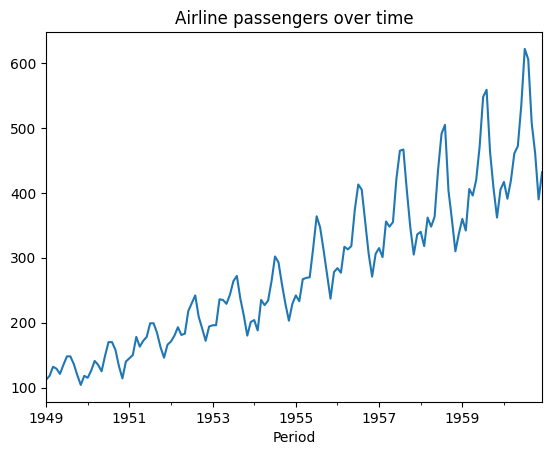

In [2]:
airline = load_airline()
airline.index = airline.index.to_timestamp()  # convert the period index to timestamp
fig = airline.plot(title='Airline passengers over time')
plt.show()

In [3]:
# length of our time series
print(airline.shape)

(144,)


In [4]:
# periodicity of the time series
airline.index[1] - airline.index[0]

Timedelta('31 days 00:00:00')

In [5]:
144 / 12

12.0

So what are the characteristics that distinguish time series from other form of dataset?
- Time series data is ordered, meaning that the order of the data points is important
- points are usually equally spaced in time (usual algorithms need this property which can be ensured during the preprocessing)
- time series can be both univariate and multivariate, today we will be focusing on univariate time series
- time series has certain properties that we will tackle in the upcoming section

### 1.2 Basic time series properties
Time series can have various properties of which today we will be focusing on the following:
- Trend: a long-term increase or decrease in the data
- Seasonality: a pattern that repeats at regular intervals (e.g. daily, weekly, monthly, yearly)
- TODO: Could you think of some examples for each of the categories?



Solution:
- daily seasonality: the number of people visiting a park
- weekly seasonality: the number of people visiting a church
- monthly seasonality: the number of people going to Postal office (e.g. picking up their rents)
- yearly seasonality: toy sales

In [6]:
airline_decomposed = seasonal_decompose(airline, period=12)

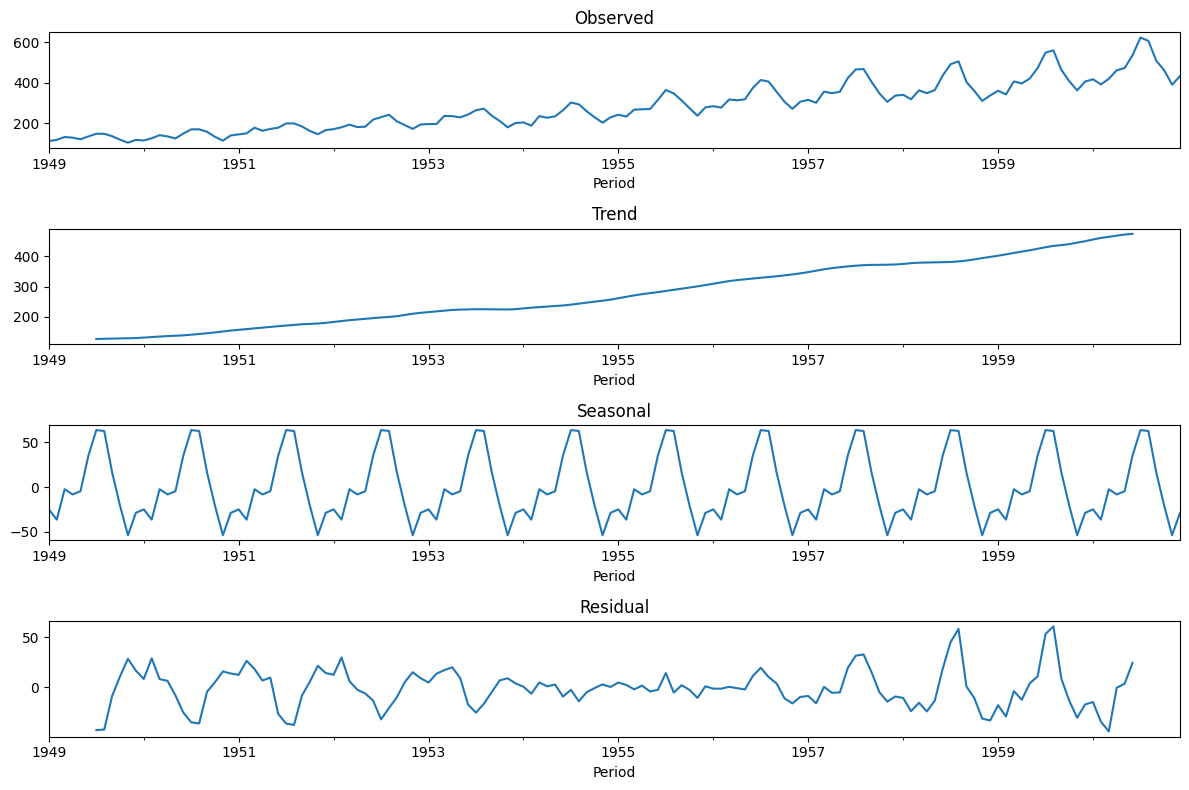

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

airline_decomposed.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
airline_decomposed.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
airline_decomposed.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
airline_decomposed.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

### 1.3 Advanced time series properties

Apart from the basic properties, time series can have more advanced properties such as:
- Autocorrelation: the correlation of a time series with a lagged version of itself
- Partial autocorrelation: the correlation of a time series with a lagged version of itself after removing the effect of the intermediate lags
- Stationarity: a property of time series where the mean, variance and autocorrelation structure do not change over time
- Hetereoskedasticity: a property of time series where the variance of the time series changes over time

#### 1.3.1 Autocorrelation
Autocorrelation is a measure of how a time series is correlated with a lagged version of itself. It is a useful property to
understand the underlying structure of the time series and can be used to identify the order of the autoregressive model.

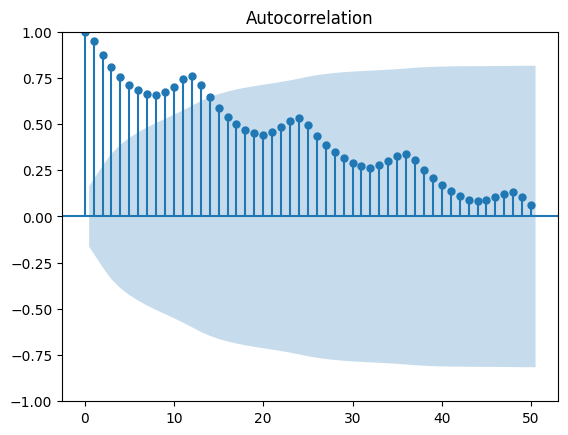

In [8]:
plot_acf(airline, lags=50)
plt.show()

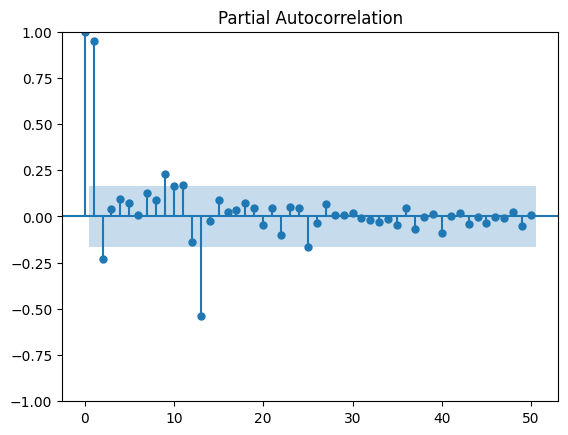

In [9]:
plot_pacf(airline, lags=50)
plt.show()

### 1.3.2 Stationarity
Stationarity is a property of time series where the mean, variance and autocorrelation structure do not change over time.
It is an important property for time series analysis as many of the time series models assume that the time series is stationary.
It can be tested using the Augmented Dickey-Fuller test.

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(airline)
print(adf_result[1])

0.991880243437641


The p-value of the Augmented Dickey-Fuller test is 0.99 which is greater than 0.05. This means that we fail to reject the null hypothesis that the time series is non-stationary. We can therefore assume that the time series is non-stationary and we might need to do some transformation before the modelling. We will come to this when assessing the quality of our models

### 1.3.3 Hetereoskedasticity
Hetereoskedasticity is a property of time series where the variance of the time series changes over time. It is an important property to consider when modelling time series data as it can affect the performance of the model. It can be tested using the ARCH test.

In [11]:
from statsmodels.stats.diagnostic import het_arch
print(het_arch(airline)[1])

2.961233760503082e-22


The very low p-value of the ARCH test indicates that the time series is heteroskedastic. This means that the variance of the time series changes over time and we might need to do some transformation before the modelling.

### 1.4 Transforming the time series
In this section, we will transform the series to make it at least stationary. To do so, we will use seasonal differencing.

In [12]:
diff_airline = airline.diff().dropna()

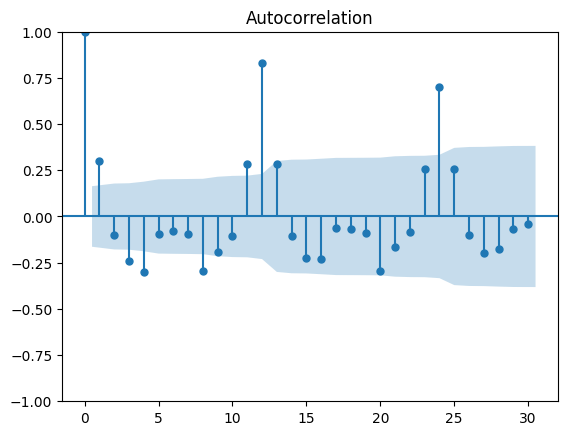

In [13]:
plot_acf(diff_airline, lags=30)
plt.show()

In [14]:
diff_decomposed = seasonal_decompose(diff_airline.dropna(), period=12)

Text(0.5, 1.0, 'Residual')

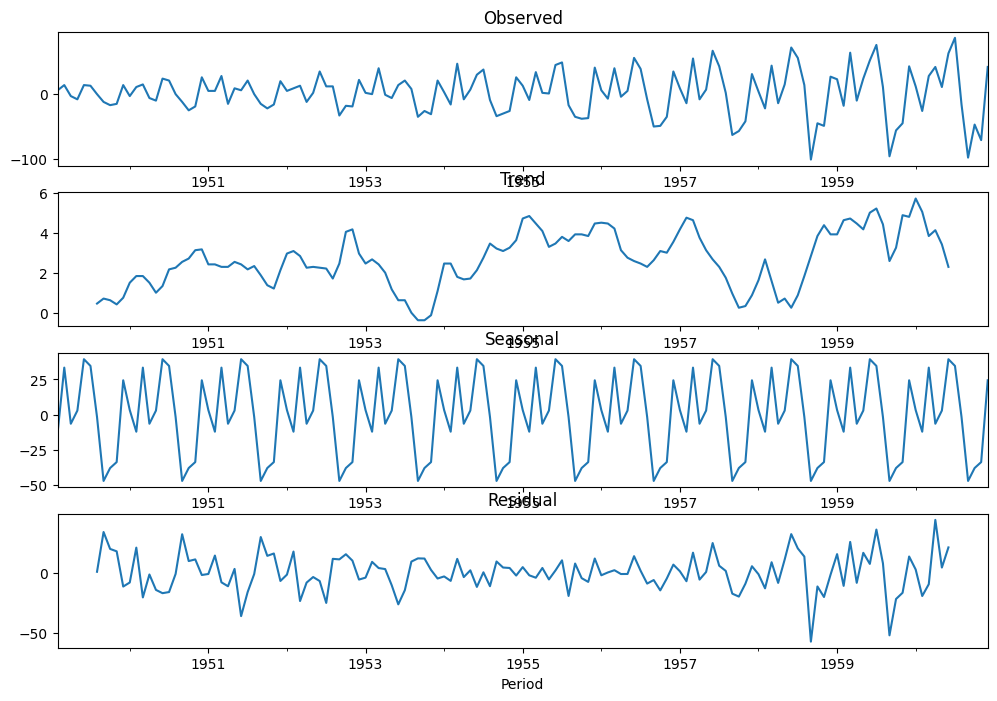

In [15]:
# make the x axis legend only at the lowest plot
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
diff_decomposed.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
diff_decomposed.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
diff_decomposed.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
diff_decomposed.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

## 2 Selecting the forecasting strategy

In this section, we will try a few forecasting approaches and evaluate which is the best one

### 2.1 Model training and cross validation

To select a model, we must select a proper strategy for model training and cross validation. The process of training stands for selecting the most appropriate set of model parameters by letting the model see new subsets of data. The process of cross validation stands for evaluating the model performance on the unseen data. In time series, we must be careful to not leak the information from the future into the past. To do so, we will be using the following strategy:

- Train the model on the first 80% of the data
- Evaluate the model on the last 20% of the data


In [16]:
train_index = airline.index[:int(0.8 * len(airline))]
test_index = airline.index[int(0.8 * len(airline)):]

In [17]:
airline_train = airline.loc[train_index]
airline_test = airline.loc[test_index]

In [18]:
airline_train.index[-1] < airline_test.index[0]

True

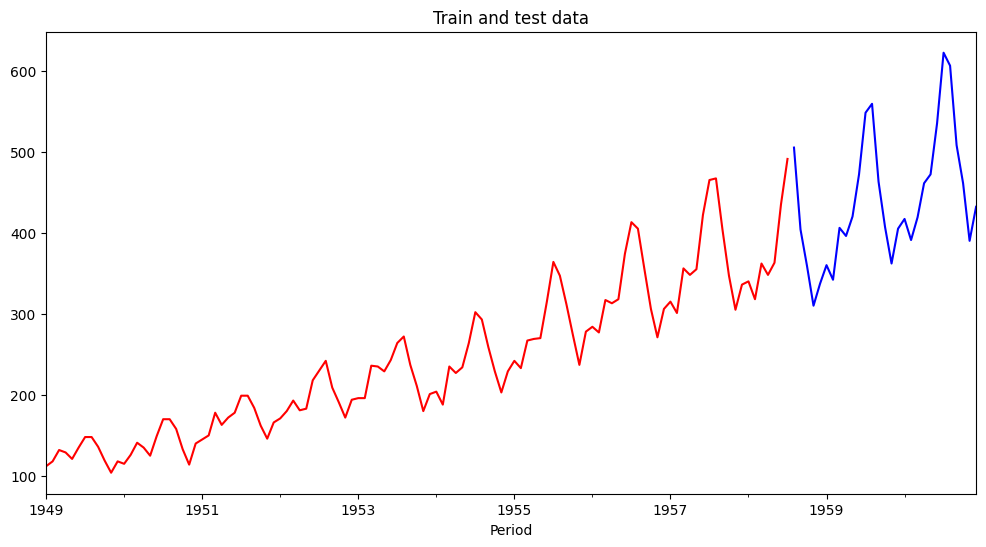

In [19]:
# let's plot the train and test data into the same plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
airline_train.plot(ax=ax, color="red", title="Train and test data")
airline_test.plot(ax=ax, color="blue")
plt.show()

### 2.2 Linear Regression

Anyone who's ever taken part in an introductory course to machine learning, must've come across a liner regressio. This method explains the target variable using a linear combination of the features, choosing such fit that minimizes. In our case, we will be using time index as a feature and number of passengers as target variable. In the next cell, we introduce the time variable which will be used as a covariate. Then we fit a basic linear regression model and predict 


In [20]:
airline_regression = pd.DataFrame(airline).assign(time=[i + 1 for i in range(len(airline))])
airline_regression

,Number of airline passengers,time
Period,,
1949-01-01,112.0,1
1949-02-01,118.0,2
1949-03-01,132.0,3
1949-04-01,129.0,4
1949-05-01,121.0,5
...,...,...
1960-08-01,606.0,140
1960-09-01,508.0,141
1960-10-01,461.0,142


In [21]:
model = LinearRegression()
model.fit(X=airline_regression.loc[train_index, ['time']], 
          y=airline_regression.loc[train_index,'Number of airline passengers'])

LinearRegression()

In [22]:
pred_regression = pd.DataFrame({'Number of airline passengers': model.predict(airline_regression.loc[test_index, ['time']]),
                       'Period': test_index}).set_index("Period")

In [23]:
full_regression = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pd.DataFrame(pred_regression).assign(data_type="regression_forecast")])

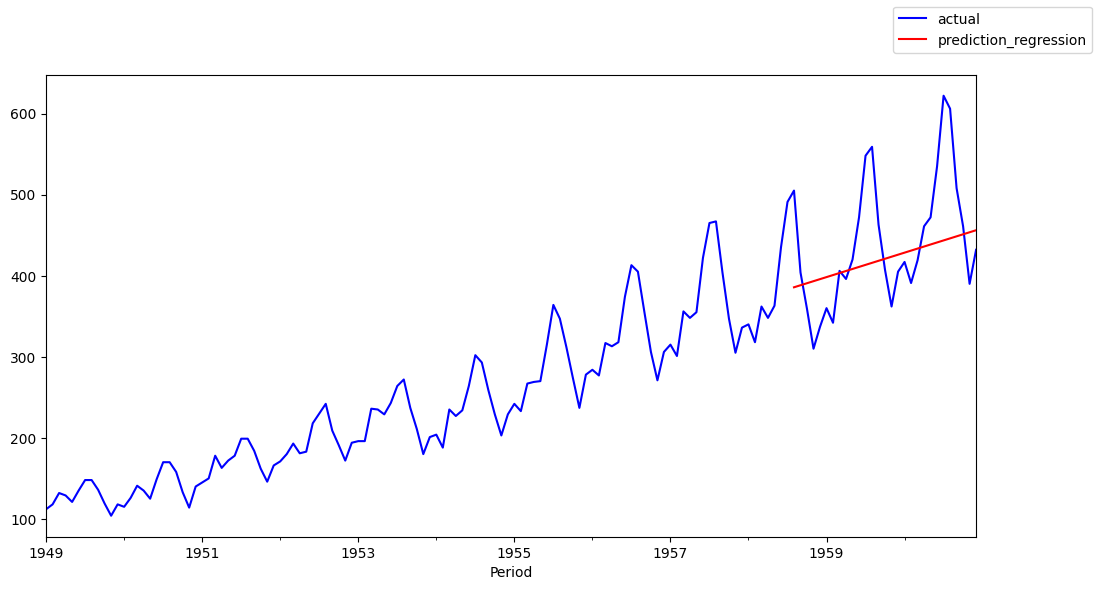

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
full_regression.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
full_regression.query('data_type == "regression_forecast"')['Number of airline passengers'].plot(ax=ax, color='red', label='prediction_regression')
fig.legend()
plt.show()

### 2.3 Predict using trend and seasonality

We've seen that linear regression fails to capture the seasonal patterns of our data and we might need to use a more sophisticated model. In this section, we will use the trend and seasonality to predict the future values of the time series.



In [25]:
df_trend = pd.concat([airline_decomposed.trend, airline_decomposed.seasonal], axis=1).assign(
    time=[i + 1 for i in range(len(airline_decomposed.trend))])


In [26]:
model = LinearRegression()
y = df_trend.loc[train_index]['trend'].dropna()
X = df_trend.loc[y.index, ['time']].dropna()
model.fit(X=X, y=y)

LinearRegression()

In [27]:
y_pred = model.predict(df_trend.loc[test_index, ['time']])  + df_trend.loc[test_index, 'seasonal']
y_pred

Period
1958-08-01    449.914402
1958-09-01    406.176096
1958-10-01    371.577941
1958-11-01    341.191908
1958-12-01    368.730117
1959-01-01    375.166053
1959-02-01    366.291383
1959-03-01    402.803077
1959-04-01    399.572346
1959-05-01    405.667373
1959-06-01    448.141188
1959-07-01    479.133943
1959-08-01    480.691091
1959-09-01    436.952785
1959-10-01    402.354630
1959-11-01    371.968597
1959-12-01    399.506805
1960-01-01    405.942742
1960-02-01    397.068072
1960-03-01    433.579766
1960-04-01    430.349035
1960-05-01    436.444062
1960-06-01    478.917877
1960-07-01    509.910632
1960-08-01    511.467780
1960-09-01    467.729474
1960-10-01    433.131319
1960-11-01    402.745285
1960-12-01    430.283494
Freq: MS, Name: seasonal, dtype: float64

In [28]:
pred_trend_seas = pd.DataFrame(y_pred).rename(columns={"seasonal": "Number of airline passengers"}).assign(data_type="trend_seas_forecast")

In [29]:
df_complete = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pred_trend_seas])

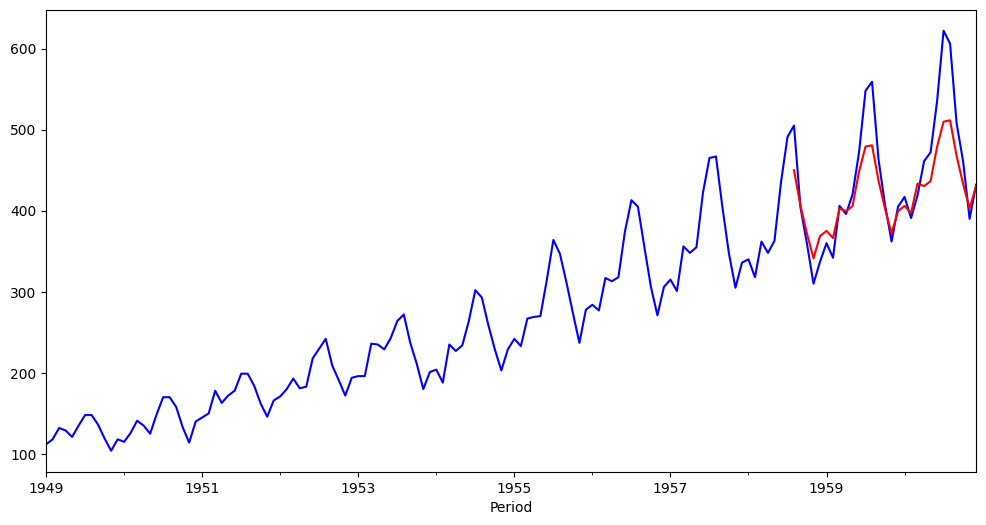

In [30]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_complete.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
df_complete.query('data_type == "trend_seas_forecast"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_trend')
plt.show()

### 3.4 Prediction using ARMA model

In [31]:
import pmdarima
forecaster = ARIMA(
    order=(1, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    suppress_warnings=True)

forecaster.fit(airline.loc[train_index].reset_index(drop=True))
y_pred = forecaster.predict(fh=[i for i in range(1, len(test_index) + 1)])

In [32]:
pred_arima = pd.DataFrame(y_pred).set_index(test_index).assign(data_type="pred_arima")

In [33]:
df_arima_full = pd.concat([pd.DataFrame(airline).assign(data_type="actual"), pred_arima])

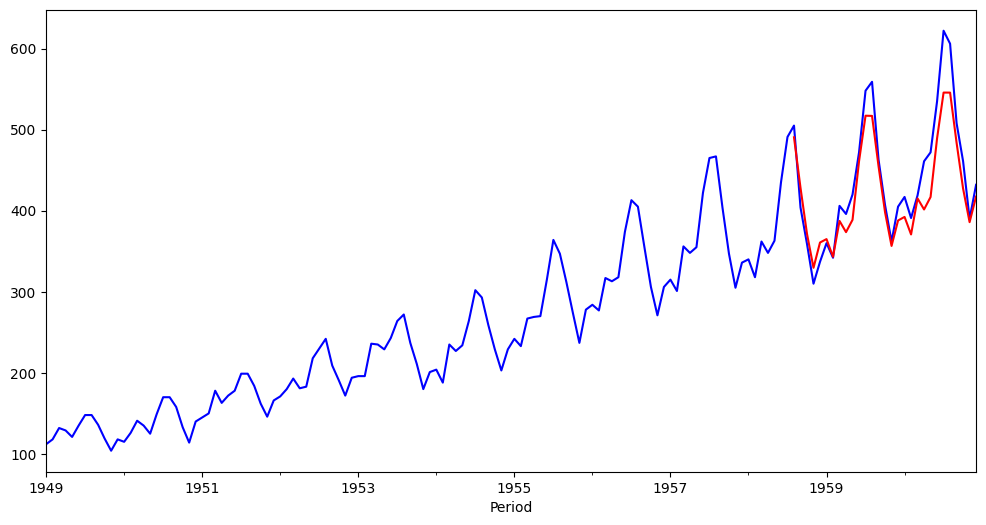

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_arima_full.query('data_type == "actual"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actual')
df_arima_full.query('data_type == "pred_arima"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_arima')
plt.show()

Now that we've estimated 3 models, we can plot the results in a single plot:

In [35]:
df_preds_all = pd.DataFrame(index=test_index)
df_preds_all = df_preds_all.assign(pred_arima=pred_arima['Number of airline passengers'],
                    pred_trend=pred_trend_seas['Number of airline passengers'],
                    pred_regression=pred_regression['Number of airline passengers']).reset_index().melt(id_vars="Period",
                                                                                                var_name="data_type",
                                                                                                value_name="Number of airline passengers").set_index("Period")
df_preds_all

,data_type,Number of airline passengers
Period,,
1958-08-01,pred_arima,490.572611
1958-09-01,pred_arima,428.306359
1958-10-01,pred_arima,371.392376
1958-11-01,pred_arima,329.611116
1958-12-01,pred_arima,360.802660
...,...,...
1960-08-01,pred_regression,446.060743
1960-09-01,pred_regression,448.574315
1960-10-01,pred_regression,451.087888


In [36]:
df_all = pd.concat([pd.DataFrame(airline).assign(data_type="actuals"), 
                    df_preds_all], axis=0).reset_index().sort_values(['Period', 'data_type']).set_index("Period")

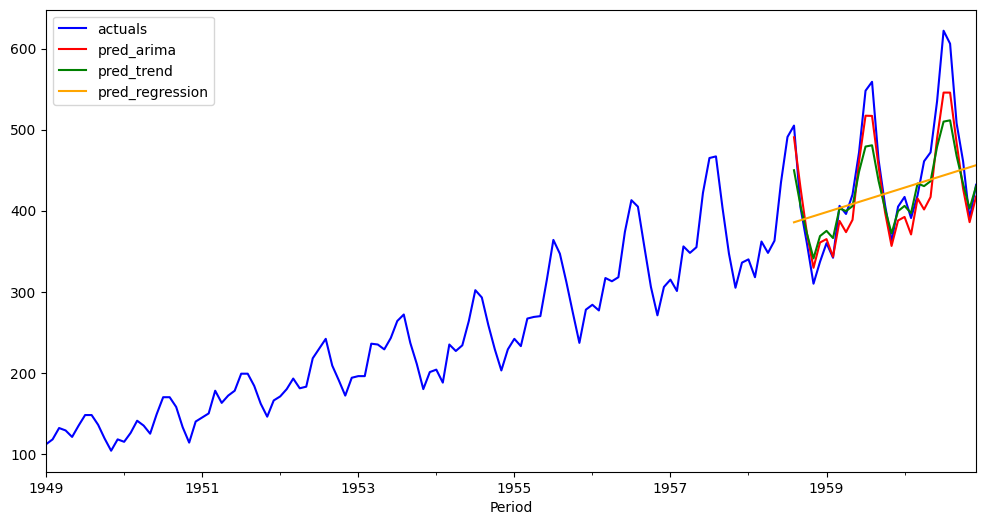

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_all.query('data_type == "actuals"')['Number of airline passengers'].plot(ax=ax, color='blue', label='actuals')
df_all.query('data_type == "pred_arima"')['Number of airline passengers'].plot(ax=ax, color='red', label='pred_arima')
df_all.query('data_type == "pred_trend"')['Number of airline passengers'].plot(ax=ax, color='green', label='pred_trend')
df_all.query('data_type == "pred_regression"')['Number of airline passengers'].plot(ax=ax, color='orange', label='pred_regression')
ax.legend()
plt.show()

## 3 Evaluating the models

In the previous section, we have estimated a few models, gradually improving the performance. However, when steering strategic decsisions, business side usually wants to have a single source of truth. To do so, we must evaluate the models and select the best one. The selection of model is usually based on some metric which compares the actual and predicted values. In time series, we usually use the following metrics:
- Mean Absolute Percentage Error (MAPE): the average of the absolute percentage errors
- Mean Squared Error (MSE): the average of the squared errors
- Root Mean Squared Error (RMSE): the square root of the average of the squared errors

It is always important to select the metric which is most relevant to the business problem. Could you provide some reasoning for metric selection behind following scenarios?
- Business needs to have accurate planning of the yearly budget
- Business is making decisions every month, adjusting the previous month expectation

In [38]:
# Which model performs the best on average?
y_true = airline_test.loc[test_index]

y_arima = pred_arima.loc[test_index, 'Number of airline passengers']
y_trend = pred_trend_seas.loc[test_index, 'Number of airline passengers']
y_regression = pred_regression.loc[test_index, 'Number of airline passengers']

In [39]:
 for y_pred, name in zip([y_arima, y_trend, y_regression], ['arima', 'trend', 'regression']):
    print(f"MAPE for {name}: {mean_absolute_percentage_error(y_true, y_pred)}")

MAPE for arima: 0.05313208286385156
MAPE for trend: 0.06102020954841454
MAPE for regression: 0.1207138013428198


How about aggregating the errors over the whole year and only then calculating the MAPE?

In [67]:
# create a function which aggregates the errors over the year
def mape_yearly(y_true, y_pred):
    df_res_agg = pd.DataFrame(index=y_true.index)
    df_res_agg['true'] = y_true
    df_res_agg['pred'] = y_pred
    df_res_agg['year'] = df_res_agg.index.year
    
    df_res_agg = df_res_agg.groupby('year').sum()
    return mean_absolute_percentage_error(df_res_agg['true'], df_res_agg['pred'])

In [66]:
 for y_pred, name in zip([y_arima, y_trend, y_regression], ['arima', 'trend', 'regression']):
    print(f"Yearly MAPE for {name}: {mape_yearly(y_true, y_pred)}")

Yearly MAPE for arima: 0.04834285541950495
Yearly MAPE for trend: 0.037029916762411526
Yearly MAPE for regression: 0.0430816864829086
